<a href="https://colab.research.google.com/github/MADHUPRIYAAA/2303a51583-batch-22/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Initial Recommendations ---
Recommended Food Items:
                                                  Food Category  Energy(kcal)  \
545                 BAJRA ROTI (20% BAJRA & 80% WHEAT)      Veg      0.120482   
307                             KHICHDI (BASMATI RICE)      Veg      0.175246   
554  Missi Roti(1/3 Besan & 1/3 Wheat Atta & 1/3 Wh...      Veg      0.818182   
524                             Banana Bread (Eggless)      Veg      0.674151   
310                                 BLACK CHANNA (dry)      Veg      0.483023   

     Proteins  Carbohydrates      Fats     Fiber  Carbon Footprint(kg CO2e)  \
545  1.000000       1.000000  1.000000  1.000000                   0.002171   
307  0.330909       0.503876  0.007353  0.052083                   0.127715   
554  0.200000       0.170543  0.198529  0.204861                   0.091421   
524  0.160000       0.162145  0.044118  0.024306                   0.000053   
310  0.200000       0.071705  0.036765  0.184028              

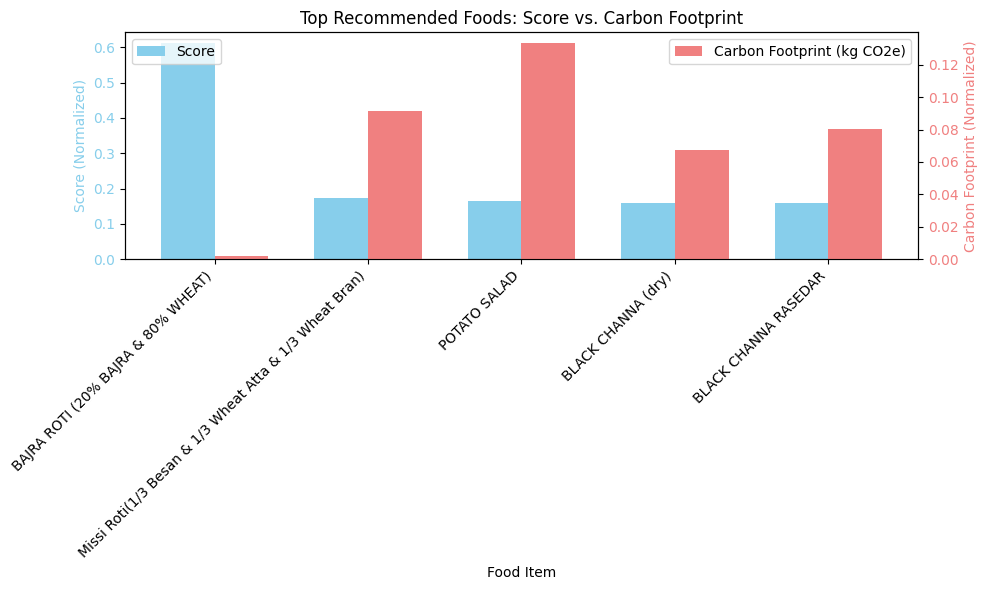

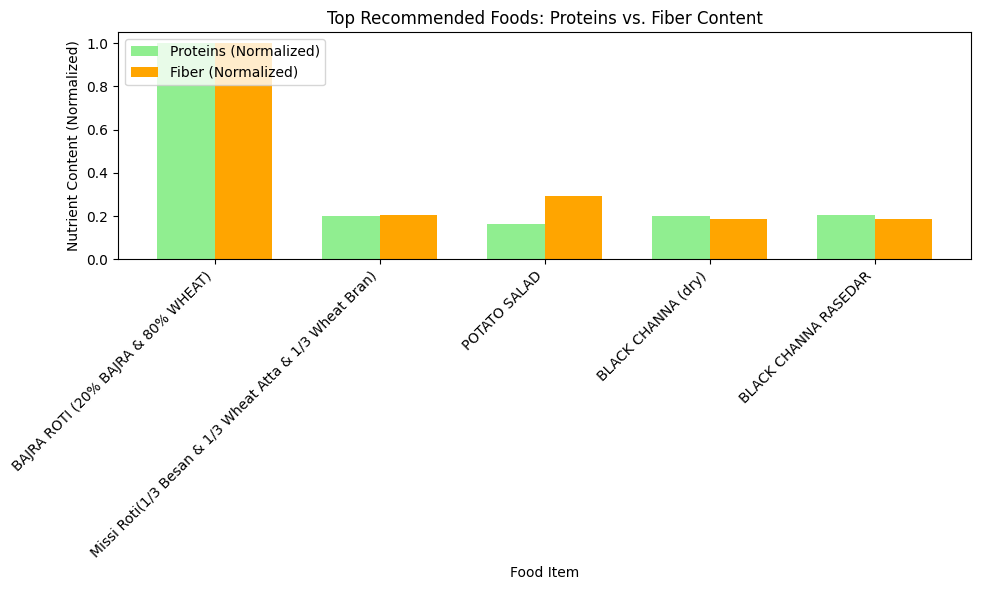

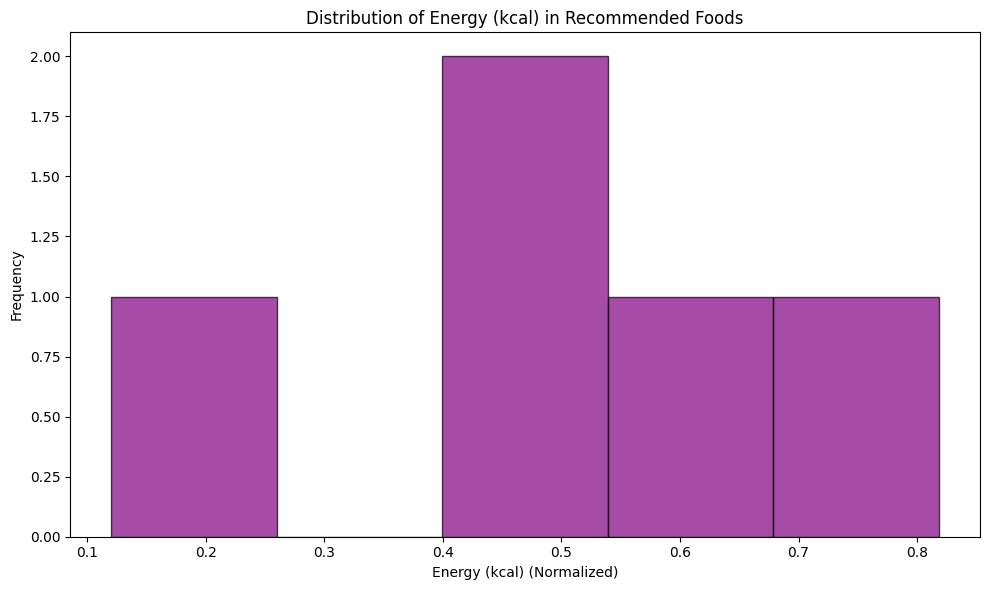

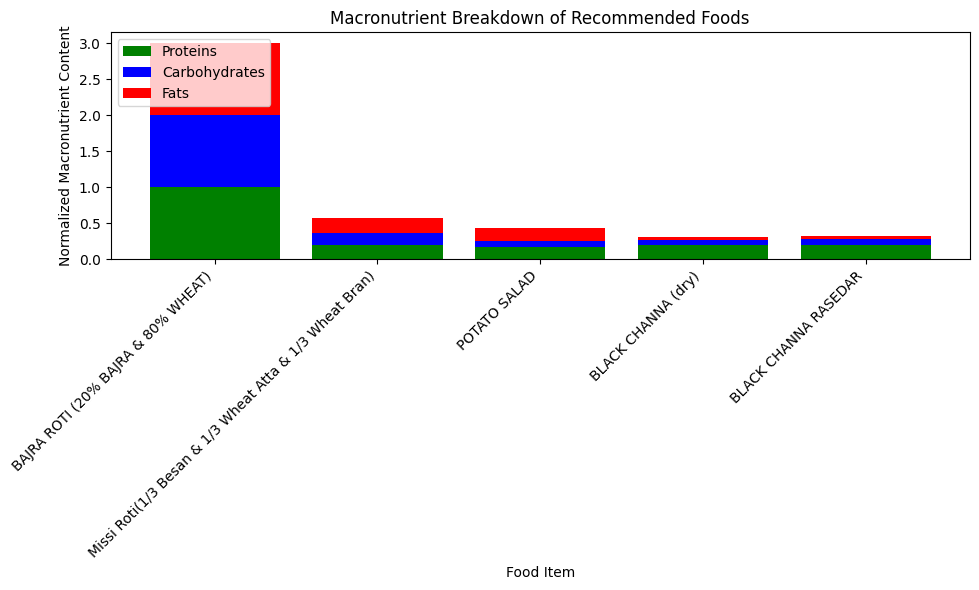

In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np # Import numpy for arange

class SustainableNutritionRecommender:
    def __init__(self, dataset_path):
        """
        Initializes the SustainableNutritionRecommender.

        Args:
            dataset_path (str): The path to the CSV dataset containing
                                 food nutrition and carbon footprint data.
        """
        self.df = pd.read_csv(dataset_path)
        self.scaler = MinMaxScaler()
        # Initialize default weights
        self.weights = {
            "Proteins": 0.3,
            "Carbohydrates": 0.1,
            "Fats": -0.2,
            "Fiber": 0.2,
            "Energy(kcal)": 0.1,
            "Carbon Footprint(kg CO2e)": -0.3
        }
        self._preprocess()

    def _preprocess(self):
        """
        Preprocesses the numerical features in the dataset by:
        1. Handling missing values (filling with median).
        2. Scaling them to a range between 0 and 1 using MinMaxScaler.
        """
        features_to_process = ["Proteins", "Carbohydrates", "Fats", "Fiber", "Energy(kcal)", "Carbon Footprint(kg CO2e)"]

        # --- NEW: Handle missing numerical values by filling with the median ---
        for feature in features_to_process:
            if self.df[feature].isnull().any():
                median_value = self.df[feature].median()
                self.df[feature] = self.df[feature].fillna(median_value)
                print(f"Filled missing values in '{feature}' with median: {median_value:.2f}")

        # Scale the defined features
        self.df[features_to_process] = self.scaler.fit_transform(self.df[features_to_process])

        # Ensure 'Allergy' column exists and fill NaN with an empty string for consistent filtering
        if 'Allergy' not in self.df.columns:
            self.df['Allergy'] = ''
        self.df['Allergy'] = self.df['Allergy'].fillna('')


    def update_weights(self, new_weights):
        """
        Updates the scoring weights for the recommender.

        Args:
            new_weights (dict): A dictionary of new weights. Only specified
                                features will be updated.
        """
        # Update existing weights with new_weights, allowing partial updates
        self.weights.update(new_weights)
        print(f"Weights updated: {self.weights}")


    def recommend(self, preference="Veg", allergy=None, max_co2=0.5, top_n=5):
        """
        Recommends food items based on dietary preferences, allergies,
        maximum carbon footprint, and a weighted scoring system.

        Args:
            preference (str, optional): Dietary preference ("Veg" or "Non-Veg"). Defaults to "Veg".
            allergy (str, optional): A keyword for allergy filtering (e.g., "soy", "nuts").
                                     Foods containing this keyword in their "Allergy" column will be excluded.
                                     Defaults to None.
            max_co2 (float, optional): Maximum allowed normalized carbon footprint (0 to 1).
                                       Defaults to 0.5.
            top_n (int, optional): The number of top recommendations to return. Defaults to 5.
            # Removed 'weights' parameter here as weights are now managed by self.weights
            # This makes the method cleaner and allows weights to be set once for the instance
            # or updated via update_weights()
        Returns:
            pandas.DataFrame: A DataFrame containing the top 'top_n' recommended food items,
                              including their nutritional information, carbon footprint,
                              ingredients, and calculated score.
        """
        data = self.df.copy()

        # Filter by dietary preference
        data = data[data["Category"] == preference]

        # Filter by allergies
        if allergy:
            data = data[~data["Allergy"].str.contains(allergy, case=False, na=False)]

        # Filter by carbon footprint
        data = data[data["Carbon Footprint(kg CO2e)"] <= max_co2]

        # Score calculation using instance weights
        data["score"] = sum(data[f] * w for f, w in self.weights.items())

        return data.sort_values(by="score", ascending=False).head(top_n)[
            ["Food", "Category", "Energy(kcal)", "Proteins", "Carbohydrates", "Fats", "Fiber",
             "Carbon Footprint(kg CO2e)", "Ingredients", "score"]
        ]

    def evaluate_recommendations(self, recommendations_df):
        """
        Evaluates the sustainability of a set of recommendations.

        Args:
            recommendations_df (pd.DataFrame): DataFrame of recommended food items.

        Returns:
            dict: A dictionary containing evaluation metrics (e.g., average carbon footprint).
        """
        if recommendations_df.empty:
            return {"average_carbon_footprint_normalized": 0, "num_recommendations": 0}

        avg_co2 = recommendations_df["Carbon Footprint(kg CO2e)"].mean()
        return {
            "average_carbon_footprint_normalized": avg_co2,
            "num_recommendations": len(recommendations_df)
        }


if __name__ == "__main__":
    # Ensure 'nutrition_cf - Sheet5.csv' is available in the same directory
    recommender = SustainableNutritionRecommender("/content/nutrition_cf - Sheet5.csv")

    # --- Demonstrating New Features ---
    print("--- Initial Recommendations ---")
    results = recommender.recommend(preference="Veg", allergy="soy", max_co2=0.4, top_n=5)
    print("Recommended Food Items:")
    print(results)
    eval_results = recommender.evaluate_recommendations(results)
    print(f"Evaluation: Average Carbon Footprint (Normalized): {eval_results['average_carbon_footprint_normalized']:.3f}")

    print("\n--- Updating Weights (e.g., to strongly prioritize Fiber) ---")
    recommender.update_weights({"Fiber": 0.5, "Proteins": 0.2}) # Higher fiber weight, slightly lower protein
    results_updated_weights = recommender.recommend(preference="Veg", allergy="soy", max_co2=0.4, top_n=5)
    print("Recommended Food Items with Updated Weights:")
    print(results_updated_weights)
    eval_updated_weights = recommender.evaluate_recommendations(results_updated_weights)
    print(f"Evaluation: Average Carbon Footprint (Normalized): {eval_updated_weights['average_carbon_footprint_normalized']:.3f}")

    # --- Visualization Section (using the final set of recommendations for demonstration) ---
    if not results_updated_weights.empty: # Use the latest results for visualization
        # --- 1. Bar Graph: Score vs. Carbon Footprint ---
        fig1, ax1 = plt.subplots(figsize=(10, 6)) # Create a new figure and axes for this plot

        bar_width = 0.35
        index = np.arange(len(results_updated_weights))

        # Plot Score as bars on the left y-axis
        bar1 = ax1.bar(index - bar_width/2, results_updated_weights["score"], bar_width, label='Score', color='skyblue')
        ax1.set_xlabel('Food Item')
        ax1.set_ylabel('Score (Normalized)', color='skyblue')
        ax1.tick_params(axis='y', labelcolor='skyblue')
        ax1.set_title('Top Recommended Foods: Score vs. Carbon Footprint')
        ax1.set_xticks(index)
        ax1.set_xticklabels(results_updated_weights["Food"], rotation=45, ha="right") # Rotate labels for readability
        ax1.legend(loc='upper left')

        # Create a second y-axis for Carbon Footprint
        ax2 = ax1.twinx()
        bar2 = ax2.bar(index + bar_width/2, results_updated_weights["Carbon Footprint(kg CO2e)"], bar_width, label='Carbon Footprint (kg CO2e)', color='lightcoral')
        ax2.set_ylabel('Carbon Footprint (Normalized)', color='lightcoral')
        ax2.tick_params(axis='y', labelcolor='lightcoral')
        ax2.legend(loc='upper right')

        fig1.tight_layout() # Adjust layout to prevent labels overlapping
        plt.show() # Display the plot

        # --- 2. Bar Graph: Proteins vs. Fiber Content ---
        fig2, ax3 = plt.subplots(figsize=(10, 6)) # New figure for the second bar graph

        bar_width_nutrients = 0.35
        index_nutrients = np.arange(len(results_updated_weights))

        bar3 = ax3.bar(index_nutrients - bar_width_nutrients/2, results_updated_weights["Proteins"], bar_width_nutrients, label='Proteins (Normalized)', color='lightgreen')
        bar4 = ax3.bar(index_nutrients + bar_width_nutrients/2, results_updated_weights["Fiber"], bar_width_nutrients, label='Fiber (Normalized)', color='orange')

        ax3.set_xlabel('Food Item')
        ax3.set_ylabel('Nutrient Content (Normalized)')
        ax3.set_title('Top Recommended Foods: Proteins vs. Fiber Content')
        ax3.set_xticks(index_nutrients)
        ax3.set_xticklabels(results_updated_weights["Food"], rotation=45, ha="right")
        ax3.legend(loc='upper left')
        fig2.tight_layout()
        plt.show() # Display the plot

        # --- 3. Histogram: Distribution of Energy (kcal) ---
        fig3, ax4 = plt.subplots(figsize=(10, 6)) # New figure for the histogram

        ax4.hist(results_updated_weights["Energy(kcal)"], bins=5, color='purple', edgecolor='black', alpha=0.7)
        ax4.set_xlabel('Energy (kcal) (Normalized)')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Distribution of Energy (kcal) in Recommended Foods')
        fig3.tight_layout()
        plt.show() # Display the plot

        # --- 4. Stacked Bar Chart: Macronutrient Breakdown ---
        fig4, ax5 = plt.subplots(figsize=(10, 6)) # New figure for the stacked bar chart

        # Stacked bar chart for Proteins, Carbohydrates, and Fats
        p1 = ax5.bar(results_updated_weights["Food"], results_updated_weights["Proteins"], color='green', label='Proteins')
        p2 = ax5.bar(results_updated_weights["Food"], results_updated_weights["Carbohydrates"], bottom=results_updated_weights["Proteins"], color='blue', label='Carbohydrates')
        p3 = ax5.bar(results_updated_weights["Food"], results_updated_weights["Fats"], bottom=results_updated_weights["Proteins"] + results_updated_weights["Carbohydrates"], color='red', label='Fats')

        ax5.set_xlabel('Food Item')
        ax5.set_ylabel('Normalized Macronutrient Content')
        ax5.set_title('Macronutrient Breakdown of Recommended Foods')
        ax5.set_xticks(np.arange(len(results_updated_weights["Food"]))) # Ensure ticks align with food names
        ax5.set_xticklabels(results_updated_weights["Food"], rotation=45, ha="right")
        ax5.legend(loc='upper left')
        fig4.tight_layout()
        plt.show() # Display the plot

    else:
        print("\nNo recommendations to visualize.")